In [1]:
import os
import numpy as np
import networkx as nx
from skimage import io
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
from scipy.spatial.distance import euclidean

import torch
from skimage.segmentation import slic
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import slic
from skimage.color import label2rgb
from skimage.util import img_as_float

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/sample\ data

/content/drive/MyDrive/sample data


In [4]:
pwd

'/content/drive/MyDrive/sample data'

In [16]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.8 MB/s eta 0:00:00


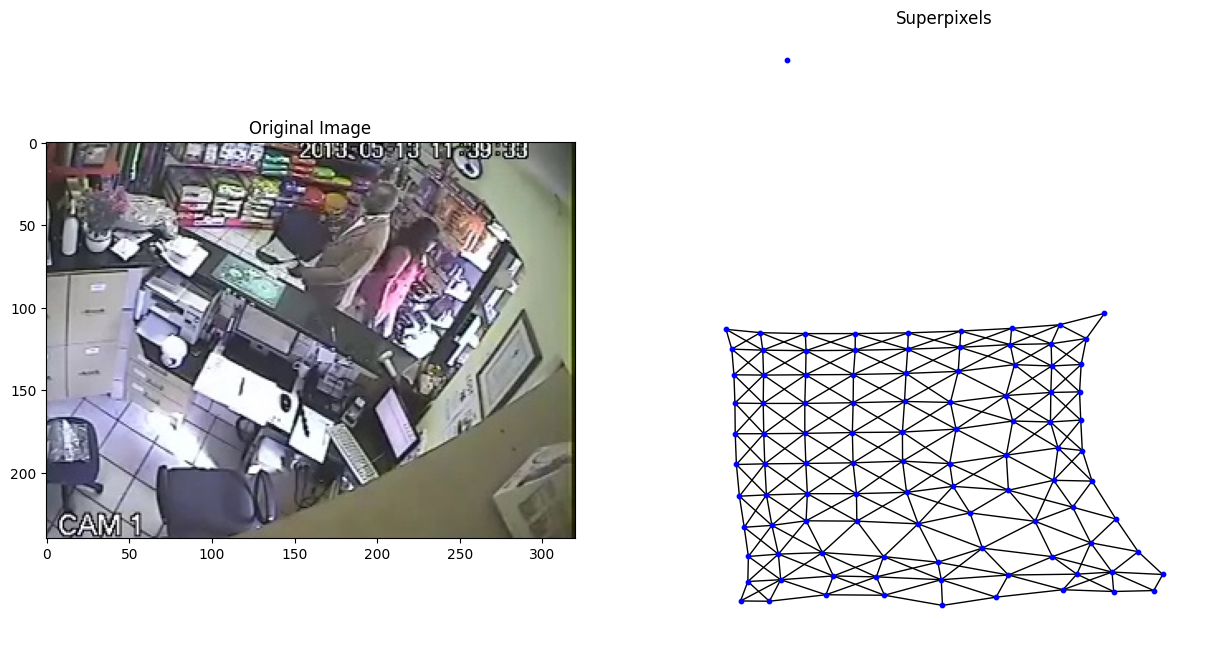


Adjacency Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 1 1 0]]


In [72]:
import networkx as nx
import matplotlib.pyplot as plt
from skimage.segmentation import slic
from skimage.color import rgb2gray
from skimage.io import imread

# Load your image (replace "batman.jpg" with your image path)
image_path = "shoplifting.jpg"
image = imread(image_path)

# Convert the image to grayscale
gray_image = rgb2gray(image)

# Perform superpixel segmentation using SLIC
segments = slic(gray_image, n_segments=100, compactness=10)

# Create a graph
G = nx.Graph()

# Add nodes (superpixels) to the graph
for segment_id in range(segments.max() + 1):
    G.add_node(segment_id)

# Add edges (adjacency) based on spatial proximity
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        current_segment = segments[i, j]
        neighbors = [(i + dx, j + dy) for dx in [-1, 0, 1] for dy in [-1, 0, 1]]
        for ni, nj in neighbors:
            if 0 <= ni < image.shape[0] and 0 <= nj < image.shape[1]:
                neighbor_segment = segments[ni, nj]
                if neighbor_segment != current_segment:
                    G.add_edge(current_segment, neighbor_segment)

# Plot the original image and its superpixels side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
axs[0].imshow(image)
axs[0].set_title("Original Image")
nx.draw(G, pos=nx.spring_layout(G, seed=42), node_size=10, node_color="b", with_labels=False, ax=axs[1])
axs[1].set_title("Superpixels")
plt.show()

# Print the adjacency matrix
adj_matrix = nx.adjacency_matrix(G).toarray()
print("\nAdjacency Matrix:")
print(adj_matrix)


In [56]:
import os
import torch
from torch.utils.data import Dataset
import numpy as np
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.segmentation import slic
import networkx as nx

class GraphImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Path to the root directory containing image folders.
            transform (callable, optional): Optional transform to be applied on the adjacency matrix.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        image_folders = sorted(os.listdir(root_dir))
        self.label_dict = {folder: idx for idx, folder in enumerate(image_folders)}

        # Assuming all graphs have the same number of node features, set this accordingly
        self.num_node_features = 1  # You need to set this based on your feature generation

        self.num_classes = len(self.label_dict)  # Number of unique labels/classes in your dataset

        for folder_name in image_folders:
            folder_path = os.path.join(root_dir, folder_name)
            image_files = sorted(os.listdir(folder_path))
            for img_file in image_files:
                self.image_paths.append(os.path.join(folder_path, img_file))
                self.labels.append(self.label_dict[folder_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load and process the image
        image = imread(image_path)
        gray_image = rgb2gray(image)
        segments = slic(gray_image, n_segments=100, compactness=10)

        G = nx.Graph()

        node_features = []
        for segment_id in np.unique(segments):
            # Extract segment mask
            segment_mask = segments == segment_id
            # Compute the average color of the segment
            average_color = np.mean(gray_image[segment_mask])
            # Append the feature (can be more complex, e.g., include texture, shape)
            node_features.append([average_color])
            G.add_node(segment_id)

        # Convert list of node features to a tensor
        node_features_tensor = torch.tensor(node_features, dtype=torch.float32)

        for i in range(segments.shape[0]):
            for j in range(segments.shape[1]):
                current_segment = segments[i, j]
                neighbors = [(i + dx, j + dy) for dx in [-1, 0, 1] for dy in [-1, 0, 1] if 0 <= i + dx < segments.shape[0] and 0 <= j + dy < segments.shape[1]]
                for ni, nj in neighbors:
                    neighbor_segment = segments[ni, nj]
                    if neighbor_segment != current_segment:
                        G.add_edge(current_segment, neighbor_segment)

        adj_matrix = nx.adjacency_matrix(G).toarray()

        if self.transform:
            adj_matrix = self.transform(adj_matrix)

        adj_matrix_tensor = torch.tensor(adj_matrix, dtype=torch.float32)

        return node_features_tensor, adj_matrix_tensor, label


In [67]:
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn.functional as F

class SimpleGCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(SimpleGCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 256)
        self.conv2 = GCNConv(256, 128)
        self.conv3 = GCNConv(128, 64)
        self.conv4 = GCNConv(64, 16)
        self.conv5 = GCNConv(16, num_classes)

    def forward(self, x, edge_index, batch):
        # First GCN layer
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.3, training=self.training)

        x = F.relu(self.conv2(x, edge_index))
        #x = F.dropout(x, p=0.3, training=self.training)

        x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.conv4(x, edge_index))

        x = F.relu(self.conv5(x, edge_index))

        # Global mean pooling
        x = global_mean_pool(x, batch)  # Aggregate node features to graph features

        return F.log_softmax(x, dim=1)

In [68]:
from torch_geometric.data import DataLoader, Data
#from your_dataset_module import GraphImageDataset  # Import your dataset class

# Assuming your dataset class is correctly implemented
dataset = GraphImageDataset(root_dir="ana_data/data_graph")
print(f'length of dataset{len(dataset)}')

# Example function to convert dataset items to PyG Data objects
def to_pyg_data(node_features, adj_matrix, label):
    # Find the non-zero indices in the adjacency matrix
    edge_indices = adj_matrix.nonzero(as_tuple=False).t()

    # Create the PyG Data object
    data = Data(x=torch.tensor(node_features, dtype=torch.float),
                edge_index=edge_indices,
                y=torch.tensor([label], dtype=torch.long))
    #print(node_features.shape, adj_matrix.shape, label)
    return data

# Convert dataset to a list of PyG Data objects
pyg_dataset = [to_pyg_data(*dataset[i]) for i in range(len(dataset))]

#print(pyg_dataset.count, pyg_dataset[0])
# DataLoader
data_loader = DataLoader(pyg_dataset, batch_size=4, shuffle=True)

# Define the model
model = SimpleGCN(num_node_features=dataset.num_node_features, num_classes=dataset.num_classes)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
for data in data_loader:
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.batch)  # Pass batch tensor here
    loss = F.nll_loss(out, data.y)
    loss.backward()
    optimizer.step()
    print(f"Loss: {loss.item()}")


length of dataset38


<ipython-input-68-fa79c65b0ce6>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = Data(x=torch.tensor(node_features, dtype=torch.float),


Loss: 0.6933255791664124
Loss: 0.6946247220039368
Loss: 0.6931471824645996
Loss: 0.6931471824645996
Loss: 0.6931471824645996
Loss: 0.6931471824645996
Loss: 0.6931471824645996
Loss: 0.6931471824645996
Loss: 0.6931471824645996
Loss: 0.6931471824645996


In [ ]:
import pandas as pd

# Define the data for the table
data = {
    "Metric": ["Acc.", "Prec.", "Rec.", "F1", "Acc.", "Prec.", "Rec.", "F1"],
    "Exp1_3D_CNN": [0.58, 0.59, 0.60, 0.59, None, None, None, None],
    "Exp1_GNN": [0.47, 0.48, 0.49, 0.48, None, None, None, None],
    "Exp1_RNN": [0.46, 0.47, 0.48, 0.47, None, None, None, None],
    "Exp2_3D_CNN": [None, None, None, None, 0.46, 0.51, 0.49, 0.50],
    "Exp2_GNN": [None, None, None, None, 0.38, 0.41, 0.43, 0.42],
    "Exp2_RNN": [None, None, None, None, 0.41, 0.40, 0.41, 0.40],
    "Exp3_3D_CNN": [0.71, 0.69, 0.68, 0.68, None, None, None, None],
    "Exp3_GNN": [0.54, 0.55, 0.56, 0.55, None, None, None, None],
    "Exp3_RNN": [0.52, 0.53, 0.54, 0.53, None, None, None, None]
}

# Create the DataFrame
df = pd.DataFrame(data, index=["Acc.", "Prec.", "Rec.", "F1", "Acc.", "Prec.", "Rec.", "F1"])

# Save the DataFrame to an Excel file
file_path = "model_comparison_results.xlsx"
df.to_excel(file_path, index=False)

file_path


'model_comparison_results.xlsx'

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define a simple Graph Neural Network (GCN) model
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, adj_matrix):
        x = torch.relu(self.fc1(x))
        x = torch.matmul(adj_matrix, x)  # Graph convolution
        x = self.fc2(x)
        return x


# Split the dataset into train and test sets
train_graphs, test_graphs, train_labels, test_labels = train_test_split(
    sample_graphs, sample_labels, test_size=0.2, random_state=42
)

# Initialize the GCN model
input_dim = 100  # Dimension of node features (size of adjacency matrix)
hidden_dim = 64
output_dim = 2  # Number of classes (binary classification)
model = GCN(input_dim, hidden_dim, output_dim)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(train_graphs, train_graphs)  # Use adjacency matrix as input features
    loss = criterion(outputs, train_labels.long())  # Convert labels to long type

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}]: Loss = {loss.item()}")

# Evaluate on the test set
model.eval()
with torch.no_grad():
    test_outputs = model(test_graphs, test_graphs)
    _, predicted_labels = torch.max(test_outputs, 1)

    accuracy = accuracy_score(test_labels, predicted_labels)
    precision = precision_score(test_labels, predicted_labels)
    recall = recall_score(test_labels, predicted_labels)
    f1 = f1_score(test_labels, predicted_labels)

    print(f"Test Accuracy: {accuracy:.2f}")
    print(f"Test Precision: {precision:.2f}")
    print(f"Test Recall: {recall:.2f}")
    print(f"Test F1 Score: {f1:.2f}")

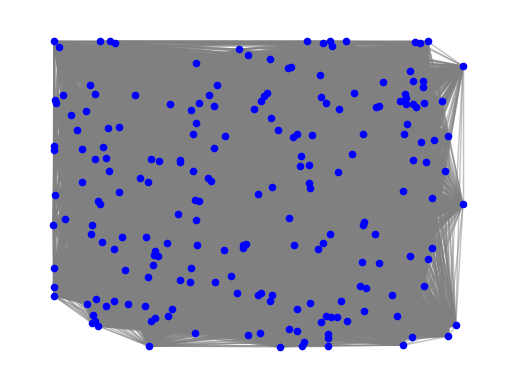

In [ ]:
import torch
import numpy as np
import networkx as nx
from skimage import io
from skimage.color import rgb2gray
from skimage.measure import label, regionprops
from skimage.filters import threshold_otsu
from scipy.spatial.distance import euclidean

# Since we don't have an actual image, let's create a random 6-channel tensor as a placeholder.
# The first 3 channels simulate RGB, and the remaining 3 are additional data channels.
six_channel_tensor = torch.rand(6, 256, 256)

# Function to convert a 6-channel tensor into superpixels and then extract a graph from those superpixels
def extract_superpixels_from_tensor(tensor_image):
    # We assume the tensor is of shape [C, H, W] and C >= 3
    # Let's use the first three channels to create a grayscale image by averaging them
    # In a real scenario, you could apply a more sophisticated method to combine the channels
    gray_image = tensor_image.mean(dim=0).numpy()



    # Threshold the grayscale image
    threshold_value = threshold_otsu(gray_image)
    binary_image = gray_image > threshold_value

    # Label connected components
    labeled_image = label(binary_image)

    # Create a graph
    G = nx.Graph()

    # Add nodes (superpixels) with attributes
    for region in regionprops(labeled_image):
        # We take the region label and its centroid
        centroid = region.centroid
        # Nodes are added with 'pos' as an attribute, which is a tuple of the centroid coordinates
        G.add_node(region.label, pos=(centroid[1], centroid[0]))

    # Add edges (connect neighboring superpixels) based on some criteria, for instance, Euclidean distance
    # Here we connect each node with every other node. In a real scenario, you'd connect only adjacent nodes.
    for node_i in G.nodes:
        for node_j in G.nodes:
            if node_i != node_j:
                pos_i = np.array(G.nodes[node_i]['pos'])
                pos_j = np.array(G.nodes[node_j]['pos'])
                weight = euclidean(pos_i, pos_j)
                G.add_edge(node_i, node_j, weight=weight)

    return G, gray_image

# Extract the graph from the 6-channel tensor
superpixels_graph, g = extract_superpixels_from_tensor(six_channel_tensor)

# Now we can draw the graph
# As an example, let's plot it with matplotlib
positions = nx.get_node_attributes(superpixels_graph, 'pos')
weights = nx.get_edge_attributes(superpixels_graph, 'weight')

# Drawing the nodes
nx.draw_networkx_nodes(superpixels_graph, positions, node_size=20, node_color='blue')

# Drawing the edges with weights
nx.draw_networkx_edges(superpixels_graph, positions, alpha=0.5, edge_color='gray')

# Removing axis for better clarity

plt.axis('off')
plt.show()

In [ ]:
g.shape

(256, 256)

In [ ]:
def extract_superpixels(image_path):
    # Read the image
    image = io.imread(image_path)
    gray_image = rgb2gray(image)

    # Threshold the image
    threshold_value = threshold_otsu(gray_image)
    binary_image = gray_image > threshold_value

    # Label connected components
    labeled_image = label(binary_image)

    # Create a graph
    G = nx.Graph()

    # Add nodes (superpixels)
    for region in regionprops(labeled_image):
        centroid = region.centroid
        G.add_node(region.label, pos=(centroid[1], centroid[0]))

    # Add edges (connect neighboring superpixels)
    for i, j in G.edges():
        pos_i = np.array(G.nodes[i]['pos'])
        pos_j = np.array(G.nodes[j]['pos'])
        weight = euclidean(pos_i, pos_j)
        G[i][j]['weight'] = weight

    return G

In [ ]:
# Example usage
image_path = "shoplifting.jpg"  # Replace with the path to your image
superpixels_graph = extract_superpixels(image_path)

NameError: name 'pos' is not defined

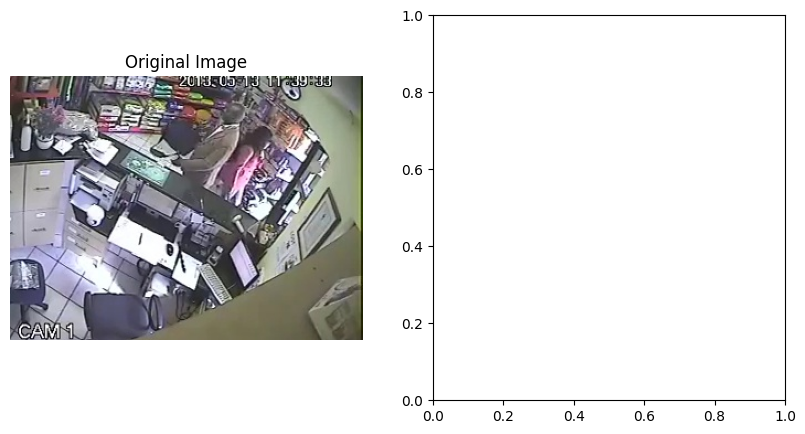

In [ ]:
import matplotlib.pyplot as plt

# Load the original image (replace with your actual image path)
original_image_path = "shoplifting.jpg"
original_image = io.imread(original_image_path)

# Create a subplot to display both images side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the original image
axs[0].imshow(original_image)
axs[0].set_title("Original Image")
axs[0].axis("off")

# Plot the superpixels graph
nx.draw(superpixels_graph, pos, with_labels=False, node_size=10, node_color='r', edge_color='gray', ax=axs[1])
axs[1].set_title("Superpixels Graph")
axs[1].axis("off")

plt.show()


In [ ]:
superpixels_graph.graph

{}